# FYP related information

Assessor: Mr Jappit Sionggo

Supervisor: Yeo Sze Wee Aaron

Project Team: FYP-23-S4-12


# MTCNN - Leaky ReLU - alpha = 0.6

Original version of the MTCNN code is used as a baseline to test against the other modified versions of this code for e.g. 'MTCNN - V2 - Contrast Adjusted' which is modified to increase facial recognition accuracy via a function that adjusts the contrast of the images.

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
# General imports
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

Note: you may need to restart the kernel to use updated packages.


In [3]:
dataset_path = "./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

# Data read-in
lfw_allnames = pd.read_csv("./lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("./lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("./lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("./lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("./lfw-dataset/mismatchpairsDevTrain.csv")

# Pre-processing
pairs = pd.read_csv("./lfw-dataset/pairs.csv")

# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("C:/Users/XZ\Desktop/lfw-dataset/people.csv")

# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("./lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("./lfw-dataset/peopleDevTrain.csv")

In [4]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [5]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print("Length of train set is:")
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print()
print("Length of test set is:")
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to proceed.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

Length of train set is:
867

Length of test set is:
815


C:\Users\XZ\AppData\Local\Temp\ipykernel_7940\889512828.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
C:\Users\XZ\AppData\Local\Temp\ipykernel_7940\889512828.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
C:\Users\XZ\AppData\Local\Temp\ipykernel_7940\889512828.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


In [6]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<Axes: >

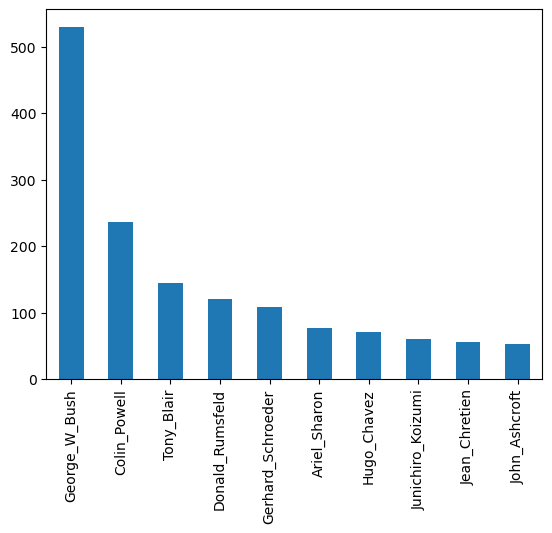

In [7]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [8]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " 
      + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) 
      + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


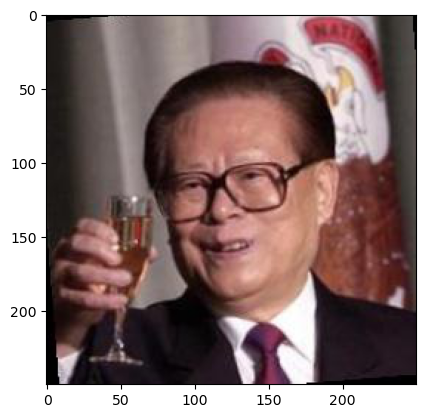

In [9]:
im = Image.open("./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

1/1 [==============================] - 0s 102ms/step


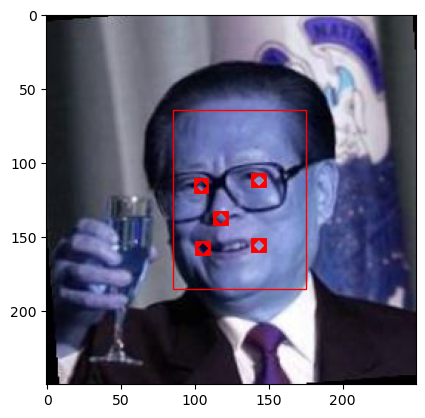

In [10]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

In [11]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [12]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [13]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D

# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [14]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))



# Bush_classifier.add(LeakyReLU())

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())


# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

import tensorflow as tf
import keras
from keras.layers import LeakyReLU

Bush_classifier.add(Dense(units = 128, activation = tf.keras.layers.LeakyReLU(alpha=0.6)))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
# Create an empty trainTestVal folder
# so no manual recreation is necessary after deletion

newpath = r'./trainTestVal' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [16]:
# define a custom function to move images to a new train/test/val directory
# after testing out original code
# original code uses a kaggle folder on desktop which contains a folder named 'working'
# created a trainTestVal folder in Desktop so it makes more sense in terms of name

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('./trainTestVal/',dir_name)):
            shutil.os.mkdir(os.path.join('./trainTestVal/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('./trainTestVal',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('./trainTestVal',dir_name,data_type))
        path_from = os.path.join('./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('./trainTestVal/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [17]:
# Move images into the 3 folders:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_test,"Bush_test/")
directory_mover(bush_val,"Bush_val/")

Moved 678 images to Bush_train/ folder.
Moved 212 images to Bush_test/ folder.
Moved 170 images to Bush_val/ folder.


In [18]:
# Run CNN algorithm
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('./trainTestVal/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Bush_test_set = test_datagen.flow_from_directory('./trainTestVal/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Bush_val_set = test_datagen.flow_from_directory('./trainTestVal/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1125 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Found 323 images belonging to 2 classes.


In [19]:
# Function to count images processed
class ImageCountCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.image_count = 0

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Processed {self.image_count} images")

    def on_batch_end(self, batch, logs=None):
        # Update the image count at the end of each batch
        self.image_count += self.params['steps']


image_count_callback = ImageCountCallback()

Bush_history = Bush_classifier.fit(Bush_training_set,
                                        # set steps per epoch equal to the number of training images
                                        steps_per_epoch = len (Bush_training_set),
                                        epochs = 8,
                                        validation_data = Bush_val_set,
                                        callbacks=[image_count_callback]
                                        )

Epoch 1/8
36/36 [==============================] - 34s 930ms/step - loss: 1.6643 - accuracy: 0.5982 - val_loss: 0.5836 - val_accuracy: 0.6533
Epoch 2/8
36/36 [==============================] - 28s 781ms/step - loss: 0.6616 - accuracy: 0.6516 - val_loss: 0.5556 - val_accuracy: 0.7276
Epoch 3/8
36/36 [==============================] - 29s 806ms/step - loss: 0.6039 - accuracy: 0.6809 - val_loss: 0.6247 - val_accuracy: 0.6440
Epoch 4/8
36/36 [==============================] - 29s 812ms/step - loss: 0.5276 - accuracy: 0.7351 - val_loss: 0.4649 - val_accuracy: 0.7895
Epoch 5/8
36/36 [==============================] - 30s 819ms/step - loss: 0.4332 - accuracy: 0.7911 - val_loss: 0.3867 - val_accuracy: 0.8266
Epoch 6/8
36/36 [==============================] - 30s 840ms/step - loss: 0.4026 - accuracy: 0.8276 - val_loss: 0.4182 - val_accuracy: 0.7957
Epoch 7/8
36/36 [==============================] - 31s 845ms/step - loss: 0.3195 - accuracy: 0.8756 - val_loss: 0.3320 - val_accuracy: 0.8483
Epoch 

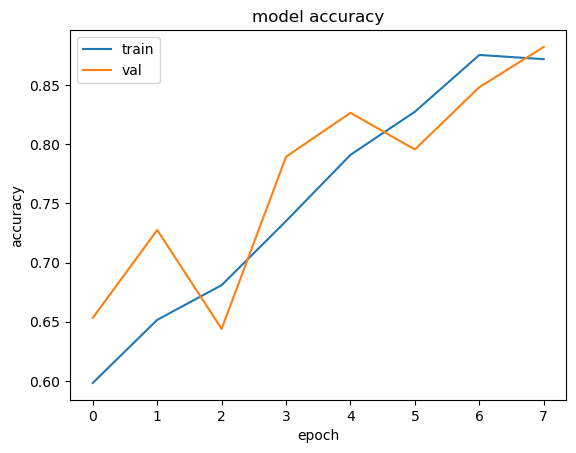

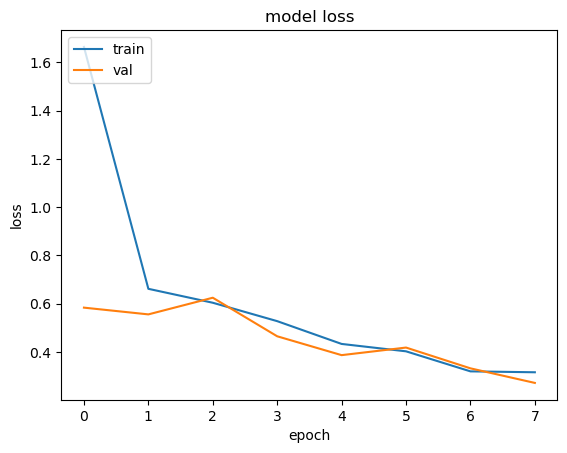

In [20]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")

In [22]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [23]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []

# collect all file names
for i in range(len(Bush_test_set.filenames)):
    class_name = os.path.basename(os.path.dirname(Bush_test_set.filenames[i]))
    Bush_test_names.append(class_name)
    
# extract unique names, in order    
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [24]:
import time

# Measure start of testing for MTCNN binary
start = time.time()

# Compute predictions
Bush_predictions_0 = predictions("./trainTestVal/Bush_test/"+ Bush_test_name_order[0] + "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("./trainTestVal/Bush_test/"+ Bush_test_name_order[1] + "/",Bush_classifier, binary = True)

# Compare predictions to actual classes
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                                columns = ['Predictions','Actual'])

1/1 [==============================] - 0s 41ms/step


In [25]:
# function for finding the accuracy, precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        
        # Check if not zero appending accuracy
        if (tp + tn) != 0 and ((tp + tn) / total_preds) != 0 :
            accuracy.append((tp + tn) / total_preds)   
        
        # Check if not zero appending precision
        if (tp + fp) != 0 and (tp / (tp + fp)) != 0:
                precision.append(tp / (tp + fp))
        
        # Check if not zero appending recall
        if (tp + fn) != 0 and (tp / (tp + fn)) != 0:
            recall.append(tp / (tp + fn))
   
    return accuracy, precision, recall

In [26]:
from statistics import mean

Bush_accuracy = prec_acc(Bush_predictions_frame)

# End of testing for MTCNN binary
end = time.time()

# According to supervisor he test time for this code is repsonse time
# Calculate total time taken for test
testTime = end - start

print(f'Response time is: {testTime:.4f} seconds')
print('')
print('Accuracy:' + str(Bush_accuracy[0]))
print('')
print('Average Accuracy:' + str(mean(Bush_accuracy[0])))
print('')
print('Precision:' + str(Bush_accuracy[1]))
print('')
print('Average Precision:' + str(mean(Bush_accuracy[1])))
print('')
print('Recall:' + str(Bush_accuracy[2]))
print('')
print('Average Recall:' + str(mean(Bush_accuracy[2])))
print('')
print('Bush Test Dataset Names:' + str(Bush_test_name_order))

Response time is: 29.4909 seconds

Accuracy:[0.8833746898263027, 0.8982630272952854, 0.9875930521091811, 0.9900744416873449, 0.9975186104218362, 0.9975186104218362, 0.9950372208436724, 0.9975186104218362]

Average Accuracy:0.9683622828784119

Precision:[0.92, 0.8925233644859814]

Average Precision:0.9062616822429908

Recall:[0.8298969072164949, 0.9138755980861244]

Average Recall:0.8718862526513096

Bush Test Dataset Names:['George_W_Bush', 'not_George']


In [27]:
if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")

In [28]:
# Obtain 6 most common celebrities
image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [29]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

In [30]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

Bush_classifier.add(Dense(units = 128, activation = tf.keras.layers.LeakyReLU(alpha=0.6)))

# As we are training on several classes, we need several classification units (one for each class). 
# Softmax activation function is used
multi_classifier.add(Dense(units = 6, activation = 'softmax'))
# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val, "val_multi/")
directory_mover(multi_test, "test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('./trainTestVal/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('./trainTestVal/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('./trainTestVal/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')

# Function to count images processed
class ImageCountCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.image_count = 0

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Processed {self.image_count} images")

    def on_batch_end(self, batch, logs=None):
        # Update the image count at the end of each batch
        self.image_count += self.params['steps']

image_count_callback = ImageCountCallback()

multi_history = multi_classifier.fit(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               # use len again to accomodate for length of training set
                                               steps_per_epoch = len(multi_training_set),
                                               # As the data is smaller, we can run for more epochs
                                               epochs = 14,
                                               callbacks=[image_count_callback],
                                               validation_data = multi_val_set)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 480 images belonging to 6 classes.
Found 138 images belonging to 6 classes.
Found 172 images belonging to 6 classes.
Epoch 1/14
15/15 [==============================] - 16s 990ms/step - loss: 18.7677 - accuracy: 0.2354 - val_loss: 5.2328 - val_accuracy: 0.2826
Epoch 2/14
15/15 [==============================] - 13s 841ms/step - loss: 2.5956 - accuracy: 0.2521 - val_loss: 2.0877 - val_accuracy: 0.1449
Epoch 3/14
15/15 [==============================] - 13s 847ms/step - loss: 1.8262 - accuracy: 0.2375 - val_loss: 1.7165 - val_accuracy: 0.3913
Epoch 4/14
15/15 [==============================] - 13s 870ms/step - loss: 1.6625 - accuracy: 0.3438 - val_loss: 1.6754 - val_accuracy: 0.3551
Epoch 5/14
15/15 [==============================] - 13s 868ms/step - loss: 1.6225 - accuracy: 0.3604 - val_loss: 1.6047 - val_accuracy: 0.4058
Epoch 6/14
15/15 [=========================

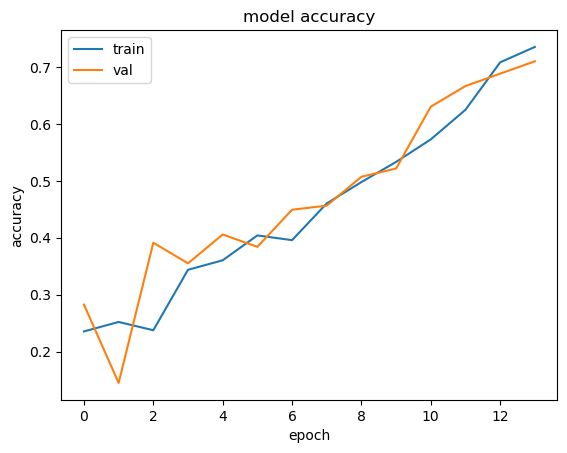

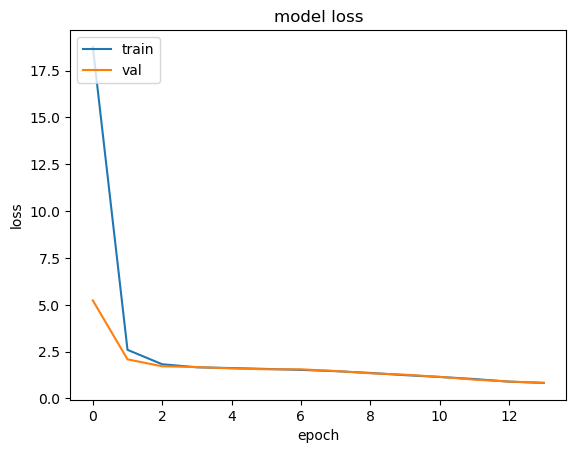

In [31]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    class_name = os.path.basename(os.path.dirname(multi_test_set.filenames[i])) 
    multi_test_names.append(class_name)

# extract unique names, in order
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [33]:
# Measure start of testing for MTCNN multiclass
startMulti = time.time()

multi_predictions_0 = predictions("./trainTestVal/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("./trainTestVal/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("./trainTestVal/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("./trainTestVal/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("./trainTestVal/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("./trainTestVal/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)

1/1 [==============================] - 0s 42ms/step


In [34]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

In [35]:
multi_accuracy = prec_acc(multi_predictions_frame)


# End of testing for MTCNN multiclass
endMulti = time.time()

# Response time
# Calculate total time taken for test
testTimeMulti = endMulti - startMulti

print(f'Response time is: {testTimeMulti:.4f} seconds')
print('')
print('Accuracy: ' + str(multi_accuracy[0]))
print('')
print('Average Multi Accuracy:' + str(mean(multi_accuracy[0])))
print('')
print('Precision:' + str(multi_accuracy[1]))
print('')
print('Average Multi Precision:' + str(mean(multi_accuracy[1])))
print('')
print('Recall:' + str(multi_accuracy[2]))
print('')
print('Average Multi Recall:' + str(mean(multi_accuracy[2])))
print('')
print('Multi Test Dataset Names:' + str(multi_test_name_order))

Response time is: 12.9068 seconds

Accuracy: [0.9186046511627907, 0.8430232558139535, 0.8837209302325582, 0.8895348837209303, 0.8953488372093024, 0.8372093023255814]

Average Multi Accuracy:0.877906976744186

Precision:[1.0, 0.5333333333333333, 0.5609756097560976, 0.47619047619047616, 0.8823529411764706, 0.5813953488372093]

Average Multi Precision:0.6723746182155979

Recall:[0.5882352941176471, 0.5517241379310345, 0.92, 0.5555555555555556, 0.4838709677419355, 0.7142857142857143]

Average Multi Recall:0.6356119449386478

Multi Test Dataset Names:['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


In [36]:
# Code to remove trainTestVal folder after code has finished running
# if you would like to see the contents of trainTestVal, please comment out the code below
shutil.rmtree('./trainTestVal')

# If you commented out the above line of code remember to delete the trainTestVal folder before running this code again
# This is to ensure testing consistency